In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:
# Load the dataset
file_path = "/root/autodl-tmp/vertigo/data/Assignment_DataScientist_20250502.csv"
df = pd.read_csv(file_path)

# Initial inspection
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (4876, 122)

First 5 rows:
   0.25_GHz_real  0.5_GHz_real  0.75_GHz_real  1.0_GHz_real  1.25_GHz_real  \
0       0.928321      0.799110       0.607104      0.430211       0.171274   
1       0.928362      0.795095       0.603138      0.428903       0.171034   
2       0.920793      0.725661       0.539412      0.415448       0.164646   
3       0.929618      0.756798       0.573948      0.448641       0.212831   
4       0.924183      0.735891       0.556284      0.417789       0.169946   

   1.5_GHz_real  1.75_GHz_real  2.0_GHz_real  2.25_GHz_real  2.5_GHz_real  \
0     -0.056632      -0.274899     -0.489029      -0.670751     -0.796667   
1     -0.059646      -0.285999     -0.501920      -0.681401     -0.802221   
2     -0.104585      -0.367430     -0.560130      -0.722270     -0.831610   
3     -0.047378      -0.304099     -0.503503      -0.677524     -0.808135   
4     -0.098664      -0.358264     -0.553657      -0.715784     -0.827924   

   ...    sensorT    TestD

## Data Cleaning (missing data handeling)

In [5]:
# Check for duplicate rows 
print(f"Total duplicate rows: {df.duplicated().sum()}")

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Convert TestDate to datetime
df['TestDate'] = pd.to_datetime(df['TestDate'], dayfirst=True)

Total duplicate rows: 0
Missing values per column:
TA    2
dtype: int64


In [6]:
# Create a unique fruit identifier combining (Experiment, Cultivar and Fruit nr)
df['UniqueFruitID'] = df['Experiment'].astype(str) + '_' + df['Cultivar'].astype(str) + '_' + df['Fruit nr'].astype(str)


In [7]:
# Check the number of unique fruits based on UniqueFruitID
unique_fruits = df['UniqueFruitID'].nunique()
print(f"Number of unique fruits: {unique_fruits}")

Number of unique fruits: 2438


In [8]:
# Count identical 'Firmness (kg)' measurements for each fruit
def count_identical_firmness(df):
    """
    Count how many pairs of 'Firmness (kg)' measurements are identical for each fruit.
    """
    identical_count = 0

    for fruit_id in df['UniqueFruitID'].unique():
        fruit_meas = df[df['UniqueFruitID'] == fruit_id]['Firmness (kg)'].values
        if len(fruit_meas) == 2 and fruit_meas[0] == fruit_meas[1]:
            identical_count += 1

    print(f"Number of fruits with identical 'Firmness (kg)' measurements: {identical_count}")

# Call the function
count_identical_firmness(df)

Number of fruits with identical 'Firmness (kg)' measurements: 7


There are 7 fruits have identical 'Firmness (kg)' measurements, while the others are not. So, 'Firmness (kg)' need to be averaged along side with the spectrum.

In [9]:
# Verify uniqueness by checking if all destructive measurements are consistent within each UniqueFruitID (except 'Firmness (kg)')
destructive_cols = ['Size', 'Weight', 'Brix', 'TA']
inconsistent_fruits = []

for fruit_id in df['UniqueFruitID'].unique():
    fruit_data = df[df['UniqueFruitID'] == fruit_id][destructive_cols]
    if not (fruit_data.nunique() == 1).all():
        inconsistent_fruits.append(fruit_id)
        print(f"Inconsistent destructive measurements for fruit {fruit_id}:")
        print(fruit_data.head(2))  # Show first 2 rows to see inconsistency

if not inconsistent_fruits:
    print("\nAll fruits have consistent destructive measurements across their multiple spectral measurements")
else:
    print(f"\nFound {len(inconsistent_fruits)} fruits with inconsistent destructive measurements")

Inconsistent destructive measurements for fruit 1_Cult3_100:
         Size  Weight  Brix  TA
598  2.992117     156  13.1 NaN
599  2.992117     156  13.1 NaN

Found 1 fruits with inconsistent destructive measurements


In [10]:
# Remove fruits with missing values from the dataset
df = df[~df['UniqueFruitID'].isin(inconsistent_fruits)]
print(f"\nDataset shape after removing inconsistent fruits: {df.shape}")


Dataset shape after removing inconsistent fruits: (4874, 123)


Checked the missing value and inconsistent destructive measurement fro each fruit, the results are consistent, which is fruit 1_Cult3_100.

Removed this fruit from dataset.

Imputing missing values is not suitable here, since there is no enough background domain knowledge, and both measurements of TA for this fruit are missing.

# Noise detection (reflection coefficient perspective)

In [11]:
# Separate real and imaginary parts of the spectrum
real_cols = df.columns[:56]
imag_cols = df.columns[56:112]


Noise Checking: perform average since both measurements are valid

In [12]:
# Detect outliers for spectral data and Firmness (kg) with precision loss handling
def detect_outliers_within_fruits(df):
    """
    Identify outlier measurements within each fruit's pair of measurements,
    including spectral data and Firmness (kg), with precision loss handling.
    """
    from scipy import stats

    # Calculate magnitude for spectral data
    df['magnitude'] = np.sqrt(df[real_cols].values**2 + df[imag_cols].values**2).mean(axis=1)

    z_scores_magnitude = []
    z_scores_firmness = []
    outlier_flags_magnitude = []
    outlier_flags_firmness = []

    for fruit_id in df['UniqueFruitID'].unique():
        fruit_meas = df[df['UniqueFruitID'] == fruit_id]
        if len(fruit_meas) == 2:
            # Magnitude outliers
            mags = fruit_meas['magnitude'].values
            if np.std(mags) > 0:  # Check if standard deviation is non-zero
                z_mag = np.abs(stats.zscore(mags))
            else:
                z_mag = np.zeros_like(mags)  # No outliers if data are identical
            z_scores_magnitude.extend(z_mag)
            outlier_flags_magnitude.extend(z_mag > 3)  # 3σ threshold

            # Firmness(kg) outliers
            firmness = fruit_meas['Firmness (kg)'].values
            if np.std(firmness) > 0:  
                z_firm = np.abs(stats.zscore(firmness))
            else:
                z_firm = np.zeros_like(firmness)  
            z_scores_firmness.extend(z_firm)
            outlier_flags_firmness.extend(z_firm > 3)  

    # Add z-scores and outlier flags to the DataFrame
    df['z_score_magnitude'] = z_scores_magnitude
    df['is_outlier_magnitude'] = outlier_flags_magnitude
    df['z_score_firmness'] = z_scores_firmness
    df['is_outlier_firmness'] = outlier_flags_firmness

    print(f"Identified {sum(outlier_flags_magnitude)} potential spectral noise in {len(df)} measurements")
    print(f"Identified {sum(outlier_flags_firmness)} potential firmness(kg) noise in {len(df)} measurements")
    return df

# Apply the updated function
df_with_noise = detect_outliers_within_fruits(df)

Identified 0 potential spectral noise in 4874 measurements
Identified 0 potential firmness(kg) noise in 4874 measurements


# Averaging firmness(kg) along with spectral measurements

In [13]:
def average_fruit_measurements(df):
    # Group by UniqueFruitID
    grouped = df.groupby('UniqueFruitID')
    
    # For non-spectral columns:
    # - Take first value for truly consistent columns
    # - Average Firmness specifically
    metadata_cols = ['TestDate', 'Experiment', 'Cultivar', 'Fruit nr', 
                    'Size', 'Weight', 'Brix', 'TA']
    metadata = grouped[metadata_cols].first()
    
    # Average Firmness
    metadata['Firmness (kg)'] = grouped['Firmness (kg)'].mean()
    
    # Average spectral measurements (real and imaginary parts)
    avg_spectra = grouped[real_cols.tolist() + imag_cols.tolist()].mean()
    
    # Combine everything
    df_avg = metadata.join(avg_spectra).reset_index()
    
    return df_avg

df_avg = average_fruit_measurements(df)

In [14]:
print(df_avg)

     UniqueFruitID   TestDate  Experiment Cultivar  Fruit nr      Size  \
0        1_Cult1_1 2024-01-18           1    Cult1         1  3.503926   
1       1_Cult1_10 2024-01-18           1    Cult1        10  3.425187   
2      1_Cult1_100 2024-01-18           1    Cult1       100  3.562981   
3       1_Cult1_11 2024-01-18           1    Cult1        11  3.208652   
4       1_Cult1_12 2024-01-18           1    Cult1        12  2.834637   
...            ...        ...         ...      ...       ...       ...   
2432    5_Cult2_95 2024-03-20           5    Cult2        95  3.385817   
2433    5_Cult2_96 2024-03-20           5    Cult2        96  2.755897   
2434    5_Cult2_97 2024-03-20           5    Cult2        97  2.677157   
2435    5_Cult2_98 2024-03-20           5    Cult2        98  2.854322   
2436    5_Cult2_99 2024-03-20           5    Cult2        99  2.834637   

      Weight  Brix      TA  Firmness (kg)  ...  11.75_GHz_imag  12.0_GHz_imag  \
0        303  14.0  0.7073    

In [15]:
# save the df_avg to a pickle file
df_avg.to_pickle("1_EDA_data.pkl")

# Visual Check

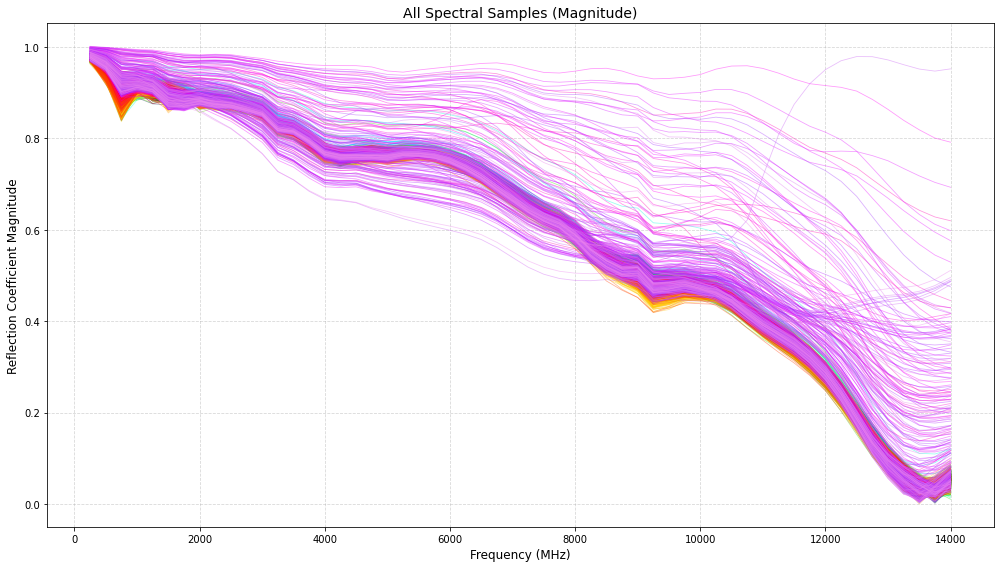

In [17]:
def plot_all_spectra(df, line_width=0.5, alpha=0.3, figsize=(14, 8)):
    """
    Plot all spectral samples in the dataset with customizable appearance

    """
    frequencies = np.linspace(250, 14000, 56)  # 250 MHz to 14 GHz
    
    fig, ax = plt.subplots(figsize=figsize)
    
    color_cycle = plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 0.9, len(df))))
    ax.set_prop_cycle(color_cycle)
    
    # Create a ScalarMappable for the colorbar
    norm = plt.Normalize(vmin=0, vmax=len(df))
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    
    for idx in range(len(df)):
        real_part = df[real_cols].iloc[idx].values.astype(float)
        imag_part = df[imag_cols].iloc[idx].values.astype(float)
        magnitude = np.sqrt(real_part**2 + imag_part**2)
        
        ax.plot(frequencies, magnitude, 
                linewidth=line_width, 
                alpha=alpha)
    
    ax.set_title('All Spectral Samples (Magnitude)', fontsize=14)
    ax.set_xlabel('Frequency (MHz)', fontsize=12)
    ax.set_ylabel('Reflection Coefficient Magnitude', fontsize=12)
    
    
    ax.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout()
    plt.show()

# Plot all samples with custom thickness
plot_all_spectra(df_avg, line_width=0.8, alpha=0.4)


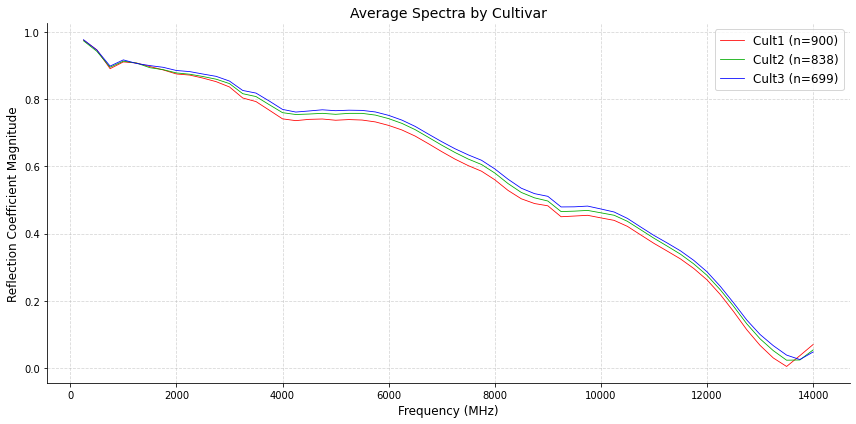

In [18]:
def plot_spectra_by_cultivar(df_clean_avg, line_width, figsize=(12, 6)):
    """
    Plot average spectra for each cultivar with distinct colors
    
    """
    frequencies = np.linspace(250, 14000, 56)  # 250 MHz to 14 GHz
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Get unique cultivars
    cultivars = df_clean_avg['Cultivar'].unique()
    
    # Define 3 very distinct colors
    distinct_colors = ['#FF0000', '#00AA00', '#0000FF']  # Red, Green, Blue
    
    # Calculate and plot average spectrum for each cultivar
    for i, cultivar in enumerate(cultivars):
        # Filter data for current cultivar
        cult_df = df_clean_avg[df_clean_avg['Cultivar'] == cultivar]
        
        # Calculate average real and imaginary parts
        avg_real = cult_df[real_cols].mean().values
        avg_imag = cult_df[imag_cols].mean().values
        
        # Calculate magnitude of average spectrum
        avg_magnitude = np.sqrt(avg_real**2 + avg_imag**2)
        
        # Plot average spectrum with distinct color
        plt.plot(frequencies, avg_magnitude,
                 linewidth=line_width,
                 color=distinct_colors[i],
                 label=f'{cultivar} (n={len(cult_df)})')
    
    # Add plot decorations
    plt.title('Average Spectra by Cultivar', fontsize=14)
    plt.xlabel('Frequency (MHz)', fontsize=12)
    plt.ylabel('Reflection Coefficient Magnitude', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Customize axes
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot average spectra by cultivar
plot_spectra_by_cultivar(df_avg, line_width=0.8)

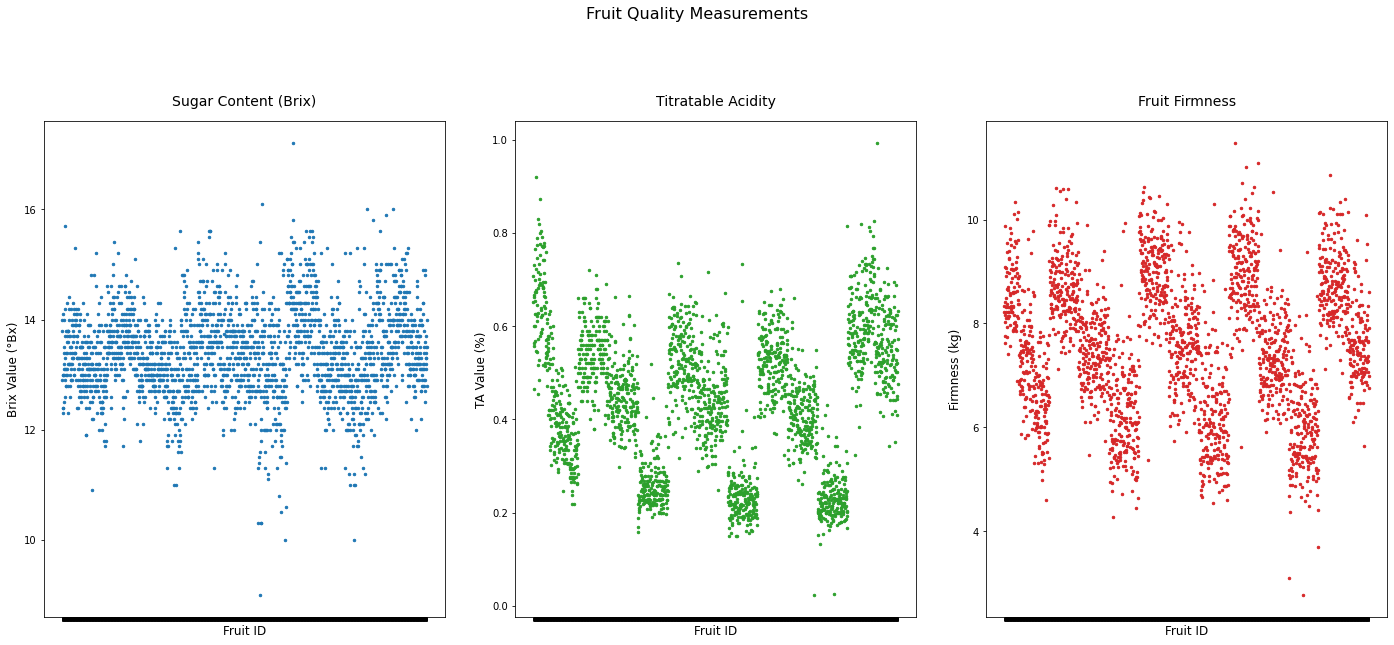

In [26]:
def plot_fruit_measurements(df, figsize=(20, 9)):
    """
    Plot Brix, TA, and Firmness (kg) for each fruit in the dataset with descriptive titles.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False)  # Removed sharey for better scaling
    
    # Custom colors with better contrast
    colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red
    
    # Plot Brix
    axes[0].scatter(df['UniqueFruitID'], df['Brix'], color=colors[0], s=6)
    axes[0].set_xlabel('Fruit ID', fontsize=12)
    axes[0].set_ylabel('Brix Value (°Bx)', fontsize=12)
    axes[0].set_title('Sugar Content (Brix)', fontsize=14, pad=15)
    axes[0].tick_params(labelbottom=False)
    
    # Plot TA (Titratable Acidity)
    axes[1].scatter(df['UniqueFruitID'], df['TA'], color=colors[1], s=6)
    axes[1].set_xlabel('Fruit ID', fontsize=12)
    axes[1].set_ylabel('TA Value (%)', fontsize=12)
    axes[1].set_title('Titratable Acidity', fontsize=14, pad=15)
    axes[1].tick_params(labelbottom=False)
    
    # Plot Firmness
    axes[2].scatter(df['UniqueFruitID'], df['Firmness (kg)'], color=colors[2], s=6)
    axes[2].set_xlabel('Fruit ID', fontsize=12)
    axes[2].set_ylabel('Firmness (kg)', fontsize=12)
    axes[2].set_title('Fruit Firmness', fontsize=14, pad=15)
    axes[2].tick_params(labelbottom=False)
    
    # Main title for the entire figure
    fig.suptitle('Fruit Quality Measurements', fontsize=16, y=1.02)
    
    # Adjust layout with more padding
    fig.tight_layout(pad=3.0)
    plt.show()

# Call the function to plot the measurements
plot_fruit_measurements(df_avg)